In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))

import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

# 第7章 量化系统-入门

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[abu量化文档教程ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

## 7.1 趋势跟踪与均值回复

### 7.1.1 趋势跟踪和均值回复可能一个时间段内在一个股票上都有所体现

In [2]:
from abupy import ABuSymbolPd
kl_pd = ABuSymbolPd.make_kl_df('usTSLA', n_folds=2)
kl_pd.tail()

In [3]:
sns.set_context(rc={'figure.figsize': (14, 7) } )
sns.regplot(x=np.arange(0, kl_pd.shape[0]), y=kl_pd.close.values, marker='+')
plt.show()

In [4]:
from abupy import ABuRegUtil

In [5]:
deg = ABuRegUtil.calc_regress_deg(kl_pd.close.values)
print('趋势角度:' + str(deg))

In [6]:
start = 0
# 前1/4的数据
end = int(kl_pd.shape[0] / 4)
# 将x也使用arange切割
x = np.arange(start, end)
# y根据start，end进行切片
y = kl_pd.close.values[start:end]
sns.regplot(x=x, y=y, marker='+')
plt.show()

In [7]:
start = int(kl_pd.shape[0] / 4)
# 向前推1/4单位个时间
end = start + int(kl_pd.shape[0] / 4)
sns.regplot(x=np.arange(start, end), y=kl_pd.close.values[start:end],
            marker='+')
plt.show()

### 7.1.2 均值回复策略


In [9]:
# 选定使用特斯拉两年的股票走势数据
kl_pd = ABuSymbolPd.make_kl_df('usTSLA', n_folds=2)
# 头一年（[:252]）作为训练数据, 美股交易中一年的交易日有252天
train_kl = kl_pd[:252]
# 后一年（[252:]）作为回测数据
test_kl = kl_pd[252:]

# 分别画出两部分数据收盘价格曲线
tmp_df = pd.DataFrame(
    np.array([train_kl.close.values, test_kl.close.values]).T,
    columns=['train', 'test'])

tmp_df[['train', 'test']].plot(subplots=True, grid=True,
                               figsize=(14, 7));

In [10]:
# 训练数据的收盘价格均值
close_mean = train_kl.close.mean()
# 训练数据的收盘价格标准差
close_std = train_kl.close.std()

# 构造卖出信号阀值
sell_signal = close_mean + close_std / 3
# 构造买入信号阀值
buy_signal = close_mean - close_std / 3

# 可视化训练数据的卖出信号阀值，买入信号阀值及均值线
plt.figure(figsize=(14, 7))
# 训练集收盘价格可视化
train_kl.close.plot()
# 水平线，买入信号线, lw代表线的粗度
plt.axhline(buy_signal, color='r', lw=3)
# 水平线，均值线
plt.axhline(close_mean, color='black', lw=1)
# 水平线， 卖出信号线
plt.axhline(sell_signal, color='g', lw=3)
plt.legend(['train close', 'buy_signal', 'close_mean', 'sell_signal'],
           loc='best')
plt.show()

# 将卖出信号阀值，买入信号阀值代入回归测试数据可视化
plt.figure(figsize=(14, 7))
# 测试集收盘价格可视化
test_kl.close.plot()
# buy_signal直接代入买入信号
plt.axhline(buy_signal, color='r', lw=3)
# 直接代入训练集均值close
plt.axhline(close_mean, color='black', lw=1)
# sell_signal直接代入卖出信号
plt.axhline(sell_signal, color='g', lw=3)
# 按照上述绘制顺序标注
plt.legend(['test close', 'buy_signal', 'close_mean', 'sell_signal'],
           loc='best')
plt.show()

print('买入信号阀值:{} 卖出信号阀值:{}'.format(buy_signal, sell_signal))

In [11]:
# 寻找测试数据中满足买入条件的时间序列
buy_index = test_kl[test_kl['close'] <= buy_signal].index

# 将找到的买入时间系列的信号设置为1，代表买入操作
test_kl.loc[buy_index, 'signal'] = 1
# 表7-2所示
test_kl[52:57]

In [12]:
# 寻找测试数据中满足卖出条件的时间序列
sell_index = test_kl[test_kl['close'] >= sell_signal].index

# 将找到的卖出时间系列的信号设置为0，代表卖出操作
test_kl.loc[sell_index, 'signal'] = 0
# 表7-3所示
test_kl[48:53]

In [13]:
# 由于假设都是全仓操作所以signal＝keep，即1代表买入持有，0代表卖出空仓
test_kl['keep'] = test_kl['signal']
# 将keep列中的nan使用向下填充的方式填充，结果使keep可以代表最终的交易持股状态
test_kl['keep'].fillna(method='ffill', inplace=True)

In [14]:
# shift(1)及np.log下面会有内容详细讲解
test_kl['benchmark_profit'] = \
    np.log(test_kl['close'] / test_kl['close'].shift(1))

# 仅仅为了说明np.log的意义，添加了benchmark_profit2，只为对比数据是否一致
test_kl['benchmark_profit2'] = \
    test_kl['close'] / test_kl['close'].shift(1) - 1

# 可视化对比两种方式计算出的profit是一致的
test_kl[['benchmark_profit', 'benchmark_profit2']].plot(subplots=True,
                                                        grid=True,
                                                        figsize=(
                                                        14, 7));

test_kl['close'].shift(1):  test_kl['close'] / test_kl['close'].shift(1) =  今日收盘价格序列／昨日收盘价格序列

In [15]:
test_kl['close'][:5]

In [16]:
test_kl['close'].shift(1)[:5]

np.log

In [17]:
np.log(220/218), 220/218 - 1.0

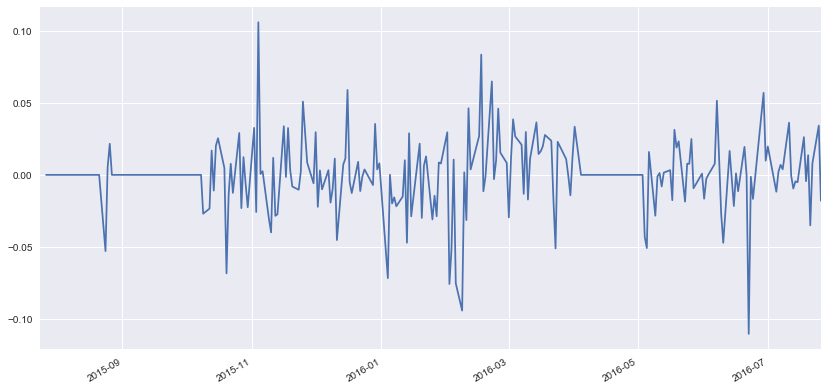

In [18]:
test_kl['trend_profit'] = test_kl['keep'] * test_kl['benchmark_profit']
test_kl['trend_profit'].plot(figsize=(14, 7))

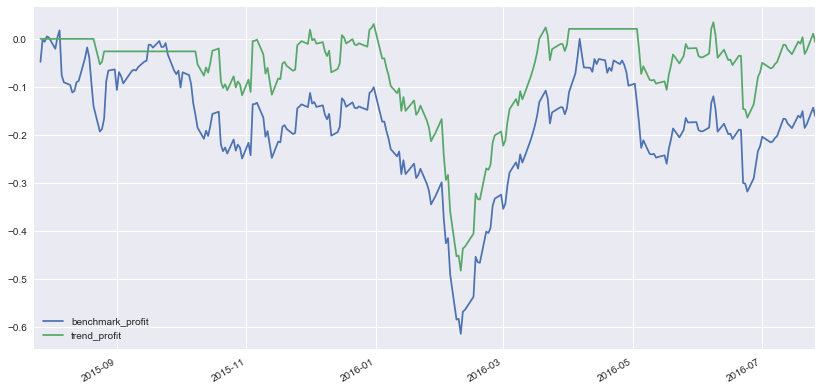

In [20]:
test_kl[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
                                                            figsize=(
                                                            14, 7));

### 对比使用np.exp

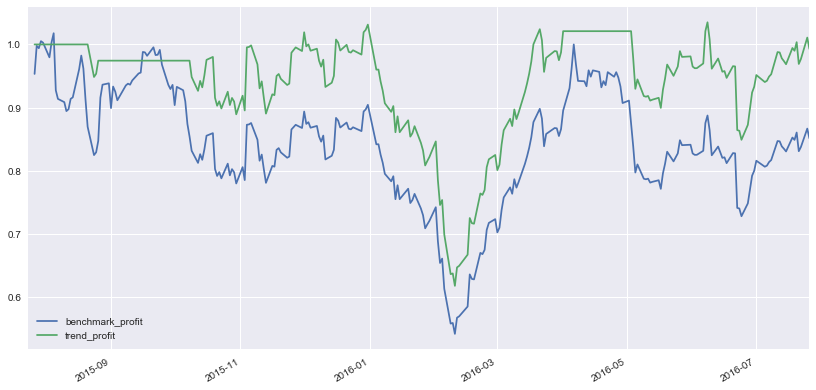

In [21]:
test_kl[['benchmark_profit', 'trend_profit']].cumsum().apply(
    np.exp).plot(grid=True);

### 7.1.3 趋势跟踪策略

In [3]:
# 当天收盘价格超过N1天内最高价格作为买入信号 
N1 = 42
# 当天收盘价格超过N2天内最低价格作为卖出信号
N2 = 21

rolling_max示例

In [4]:
from abupy import pd_rolling_max
# rolling_max示例序列
demo_list = np.array([1, 2, 1, 1, 100, 1000])
# 对示例序列以3个为一组，寻找每一组中的最大值
# pd.rolling_max(demo_list, window=3)
pd_rolling_max(demo_list, window=3)

array([   nan,    nan,     2.,     2.,   100.,  1000.])

expanding_max示例

In [5]:
# expanding_max示例序列
demo_list = np.array([1, 2, 1, 1, 100, 1000])
from abupy import pd_expanding_max
# pd.expanding_max(demo_list)
pd_expanding_max(demo_list)

array([    1.,     2.,     2.,     2.,   100.,  1000.])

In [6]:
# 通过rolling_max方法计算最近N1个交易日的最高价
# kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
# 表7-4所示
kl_pd[0:5]

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14,n1_high
2014-07-23,222.49,224.75,219.43,1.33,220.01,219.58,3088731,20140723,2,0,8.977539,8.459104,NaN
2014-07-24,223.54,225.10,220.80,0.47,223.25,222.49,3248410,20140724,3,1,8.812894,8.249168,NaN
2014-07-25,223.57,226.97,221.75,0.01,222.72,223.54,3090383,20140725,4,2,8.641804,8.032799,NaN
2014-07-28,224.82,232.00,221.40,0.56,224.25,223.57,6517611,20140728,0,3,8.735052,8.216171,NaN
2014-07-29,225.01,228.30,224.86,0.08,226.61,224.82,3387187,20140729,1,4,8.544335,7.967158,NaN


In [7]:
# expanding_max
# expan_max = pd.expanding_max(kl_pd['close']) 
expan_max = pd_expanding_max(kl_pd['close']) 
# fillna使用序列对应的expan_max
kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
# 表7-5所示
kl_pd[0:5]

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14,n1_high
2014-07-23,222.49,224.75,219.43,1.33,220.01,219.58,3088731,20140723,2,0,8.977539,8.459104,222.49
2014-07-24,223.54,225.10,220.80,0.47,223.25,222.49,3248410,20140724,3,1,8.812894,8.249168,223.54
2014-07-25,223.57,226.97,221.75,0.01,222.72,223.54,3090383,20140725,4,2,8.641804,8.032799,223.57
2014-07-28,224.82,232.00,221.40,0.56,224.25,223.57,6517611,20140728,0,3,8.735052,8.216171,224.82
2014-07-29,225.01,228.30,224.86,0.08,226.61,224.82,3387187,20140729,1,4,8.544335,7.967158,225.01


In [8]:
from abupy import pd_rolling_min, pd_expanding_min
# 通过rolling_min方法计算最近N2个交易日的最低价格
# rolling_min与rolling_max类似
# kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
# expanding_min与expanding_max类似
# expan_min = pd.expanding_min(kl_pd['close'])
expan_min = pd_expanding_min(kl_pd['close'])
# fillna使用序列对应的eexpan_min
kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

In [9]:
# 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有 
buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
kl_pd.loc[buy_index, 'signal'] = 1

# 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
kl_pd.loc[sell_index, 'signal'] = 0

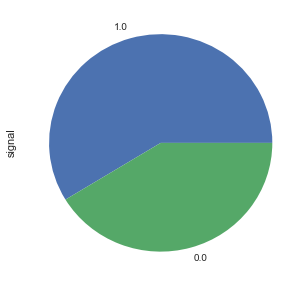

In [10]:
kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5));

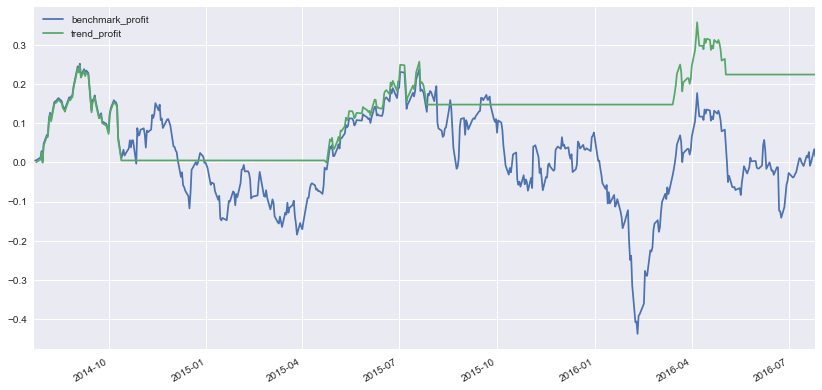

In [11]:
"""
    将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
    这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
    才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
"""
kl_pd['keep'] = kl_pd['signal'].shift(1)
kl_pd['keep'].fillna(method='ffill', inplace=True)

# 计算基准收益
kl_pd['benchmark_profit'] = np.log(
    kl_pd['close'] / kl_pd['close'].shift(1))

# 计算使用趋势突破策略的收益
kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

# 可视化收益的情况对比
kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
                                                          figsize=(
                                                          14, 7));

## 7.2 仓位控制管理

### 注意以下代码，由于有使用np.random.binomial进行随机，所以生成的数据结果与书中的会不一样

### 7.2.1 凯利公式

### 7.2.2 一支股票的时间简史

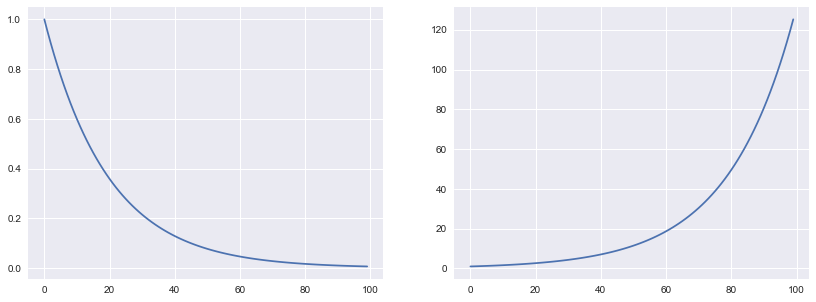

In [21]:
# 第一阶段走势涵盖股票上市后前100天走势情况
trade_day = 100
# 这个股票第一阶段走势函数gen_stock_price_array
def gen_stock_price_array():
    # 股票的初始价格是1元钱，即初始化100个初始价格是1元钱的np array
    price_array = np.ones(trade_day)

    # 以时间驱动100个交易日，生成100个交易日走势
    for ind in np.arange(0, trade_day - 1):
        if ind == 0:
            # 第一个交易日50%的概率结果是win
            win = np.random.binomial(1, 0.5)
        else:
            # 非第一个交易日它的涨跌与只与前一天的涨跌相关,如果前一天是上涨的
            # 那么它今天仍然是涨，如果它前一天是下跌的，那它今天就是跌
            win = price_array[ind] > price_array[ind - 1]

        if win:
            # 每次上涨只能上涨5%
            price_array[ind + 1] = (1 + 0.05) * price_array[ind]
        else:
            # 每次下跌只能下跌5%
            price_array[ind + 1] = (1 - 0.05) * price_array[ind]
    return price_array

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# 运行两次，生成两种走势
price_array1 = gen_stock_price_array()
price_array1_ex = gen_stock_price_array()
# 图7-13 左图
axs[0].plot(price_array1)
# 图7-13 右图
axs[1].plot(price_array1_ex)

### 第一阶段走势函数gen_stock_price_array, 不同点只有第一个交易日100%的概率结果是win

#### np.random.binomial(1, 1)


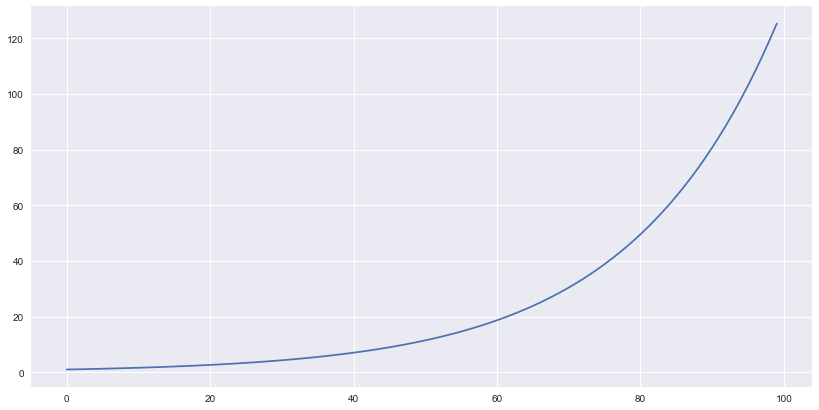

In [22]:
# 这个股票第一阶段走势函数gen_stock_price_array, 不同点只有第一个交易日100%的概率结果是win
def gen_stock_price_array():
    # 股票的初始价格是1元钱，即初始化100个初始价格是1元钱的np array
    price_array = np.ones(trade_day)

    # 以时间驱动100个交易日，生成100个交易日走势
    for ind in np.arange(0, trade_day - 1):
        if ind == 0:
            # 第一个交易日100%的概率结果是win
            win = np.random.binomial(1, 1)
        else:
            # 非第一个交易日它的涨跌与只与前一天的涨跌相关,如果前一天是上涨的
            # 那么它今天仍然是涨，如果它前一天是下跌的，那它今天就是跌
            win = price_array[ind] > price_array[ind - 1]

        if win:
            # 每次上涨只能上涨5%
            price_array[ind + 1] = (1 + 0.05) * price_array[ind]
        else:
            # 每次下跌只能下跌5%
            price_array[ind + 1] = (1 - 0.05) * price_array[ind]
    return price_array

price_array1 = gen_stock_price_array()
plt.plot(price_array1)

In [23]:
# 第二阶段走势共覆盖了252个交易日，即一年的走势
trade_day = 252


# 这个股票第二阶段走势函数gen_stock_price_array2
def gen_stock_price_array2():
    # np.concatenate连结之前100天的走势和新的252天走势
    # np.ones(trade_day) * price_array1[-1]：即新的走势使用上一阶段走势最后
    # 一天的价格初始化这个252个交易日的新序列
    price_array = np.concatenate(
        (price_array1, np.ones(trade_day) * price_array1[-1]), axis=0)

    # concatenate操作之后：price_array有352个元素
    # len(price_array1) - 1：即ind 99开始时间驱动生成第二阶段的252个交易日
    for ind in np.arange(len(price_array1) - 1, len(price_array) - 1):
        # 获取当前交易日为基准的四个交易日数据
        last4 = price_array[ind - 3:ind + 1]
        if len(last4) == 4 and last4[-1] > last4[-2] \
                and last4[-2] > last4[-3] and last4[-3] > last4[-4]:
            # 连续上涨3天, 第四及之后天下跌的概率为55%
            win = np.random.binomial(1, 0.45)
        elif len(last4) == 4 and last4[-1] < last4[-2] \
                and last4[-2] < last4[-3] and last4[-3] < last4[-4]:
            # 连续下跌3天, 第四及之后天上涨的概率为80%
            win = np.random.binomial(1, 0.8)
        else:
            # 涨跌与只与前一天的涨跌相关，如果前一天是上涨的，
            # 那么它今天仍然是涨，如果它前一天是下跌的，那它今天就是跌
            win = price_array[ind] > price_array[ind - 1]

        if win:
            # 每次上涨只能上涨5%
            price_array[ind + 1] = (1 + 0.05) * price_array[ind]
        else:
            # 每次下跌只能下跌5%
            price_array[ind + 1] = (1 - 0.05) * price_array[ind]
    return price_array

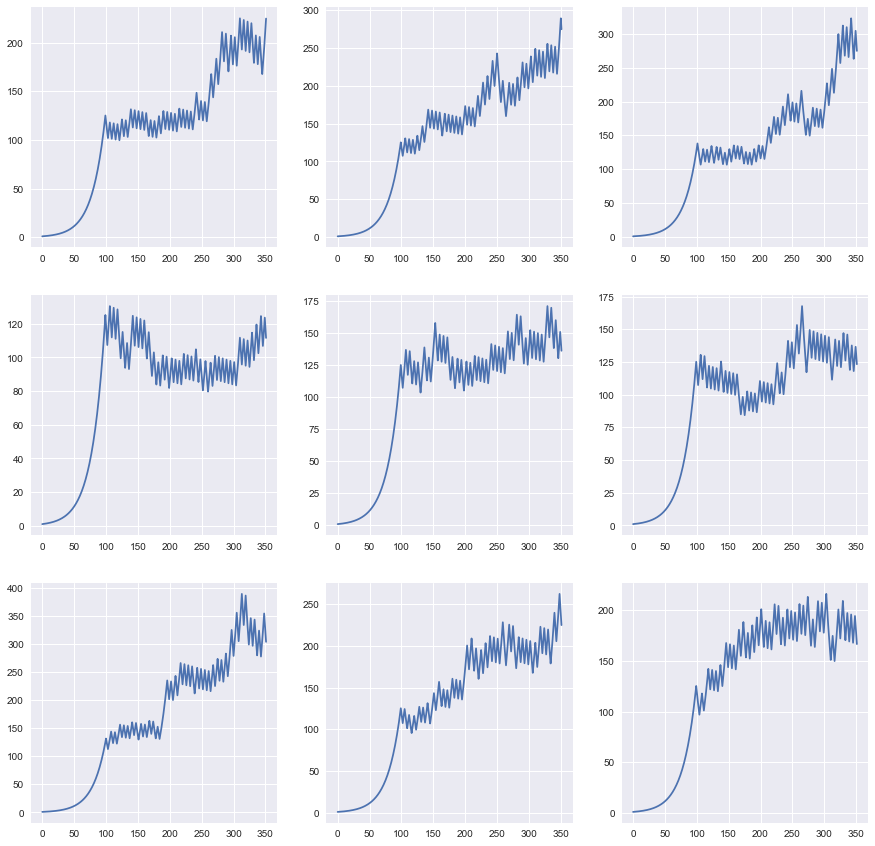

In [24]:
import itertools
# 生成9个子画布 3*3
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
# 将 3 * 3转换成一个线性list
axs_list = list(itertools.chain.from_iterable(axs))
for ax in axs_list:
    # 使用gen_stock_price_array2生成9组不同的股票走势图,使用子画布绘制
    ax.plot(gen_stock_price_array2())

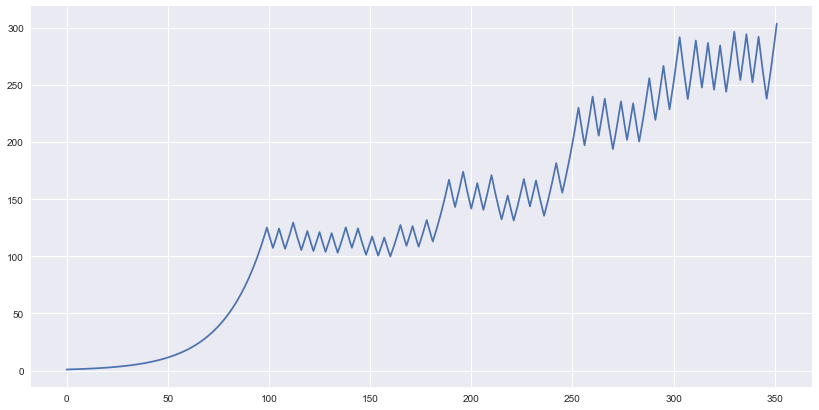

In [25]:
price_array2 = gen_stock_price_array2()
plt.plot(price_array2)

In [26]:
# 这个股票第三阶段走势函数gen_stock_price_array3
def gen_stock_price_array3():
    # np.concatenate连结之前352天的走势和新的交易日走势
    # np.ones(trade_day) * price_array2[-1]：即新的走势使用上一阶段走势最后
    # 一天的价格初始化len(trade_day)个交易日的新序列
    price_array = np.concatenate(
        (price_array2, np.ones(trade_day) * price_array2[-1]), axis=0)

    # concatenate操作之后：price_array352+len(trade_day)个元素
    # len(price_array2) - 1：即从ind 351开始时间驱动生成第三阶段的交易日数据
    for ind in np.arange(len(price_array2) - 1, len(price_array) - 1):
        # 获取当前交易日为基准的四个交易日数据
        last4 = price_array[ind - 3:ind + 1]
        if len(last4) == 4 and last4[-1] >= last4[-2] \
                and last4[-2] >= last4[-3] and last4[-3] >= last4[-4]:
            # 连续上涨3天, 第四及之后天下跌的概率为55%
            win = np.random.binomial(1, 0.45)
        elif len(last4) == 4 and last4[-1] < last4[-2] \
                and last4[-2] < last4[-3] and last4[-3] < last4[-4]:

            # 连续下跌3天, 第四及之后上涨的概率为80%
            win = np.random.binomial(1, 0.8)
            if not win:
                # 发生了灾难性的股价下跌，股价下跌50%
                price_array[ind + 1] = (1 - 0.50) * price_array[ind]
                # 直接continue了
                continue
        else:
            # 涨跌与只与前一天的涨跌相关，如果前一天是上涨的
            # 那么它今天仍然是涨，如果它前一天是下跌的，那它今天就是跌
            win = price_array[ind] >= price_array[ind - 1]

        if win:
            # 每次上涨只能上涨5%
            price_array[ind + 1] = (1 + 0.05) * price_array[ind]
        else:
            # 每次下跌只能下跌5%
            price_array[ind + 1] = (1 - 0.05) * price_array[ind]

        # 股价小于0.1元股价归0，即退市
        if price_array[ind + 1] <= 0.1:
            price_array[ind + 1:] = 0
            # 退市
            break

    return price_array

### 7.2.3 三只小猪股票投资的故事

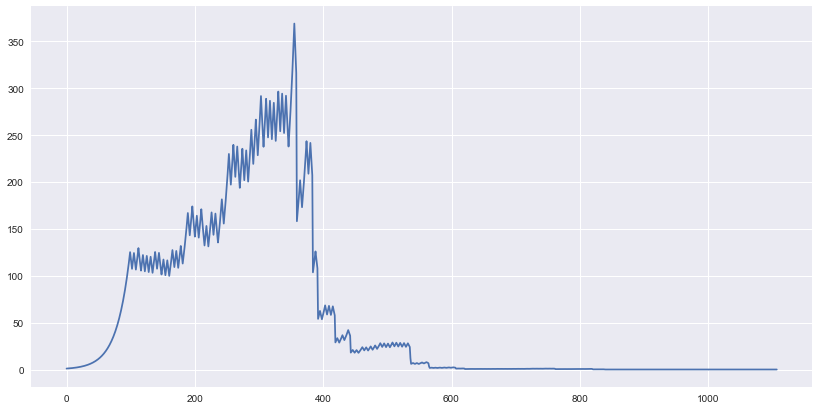

In [41]:
trade_day = 252 * 3
# price_array3即为第三阶段股票走势
price_array3 = gen_stock_price_array3()
plt.plot(price_array3)

In [28]:
def execute_trade(cash, buy_rate):
    commission = 5  # 手续费
    stock_cnt = 0  # 持有股票数
    keep_day = 0 # 持股天数
    # 资产结果序列
    capital = []
    # 从第353天开始，即从index 353开始直到最后一天
    for ind in np.arange(352, len(price_array3) - 1):
        if stock_cnt > 0:
            # 如果持有股票，增加持股天数
            keep_day += 1
        if stock_cnt > 0 and keep_day == 3:
            # 当连续持有股票三天后卖出股票
            cash += price_array3[ind] * stock_cnt
            cash -= commission  # 手续费
            if cash <= 0:
                # 如果没钱了，一切就都结束了
                capital.append(0)
                print('爆仓了!')
                break
            # 卖出后重置持股天数和持有股票数量
            keep_day = 0
            stock_cnt = 0

        # 获取当前交易日为基准5个交易日数据，5个交易日价格->4个交易日的涨跌情况
        last5 = price_array3[ind - 4:ind + 1]
        # 买入条件：
        # example: last5 = [82.4 86.5 82.2 78.1 74.2]
        # 1. 没持有股票：stock_cnt == 0
        # 2. last5序列last5[1] > last5[0] 86.5 > 82.4, 即第一个交易日上涨
        # 3. last5序列后三个交易日连续下跌[-1]<[-2],[-2]<[-3],[-3]<[-4]
        if stock_cnt == 0 and len(last5) == 5 \
                and last5[1] > last5[0] \
                and last5[-1] < last5[-2] and last5[-2] < last5[
            -3] and last5[-3] < last5[-4]:
            cash -= commission  # 手续费
            # 按照资金仓位管理buy_rate买入
            buy_cash = (cash * buy_rate)
            cash -= buy_cash
            stock_cnt += buy_cash / price_array3[ind]

            if stock_cnt < 1:
                # 如果没钱了，一切就都结束了
                capital.append(0)
                print('爆仓了!')
                break
            keep_day = 0

        # 资产结果序列加入当日结果
        capital.append(cash + (stock_cnt * price_array3[ind]))
    return capital

爆仓了!
猪老大最终资产：0
猪老大资产最高峰值：15932.70600494629


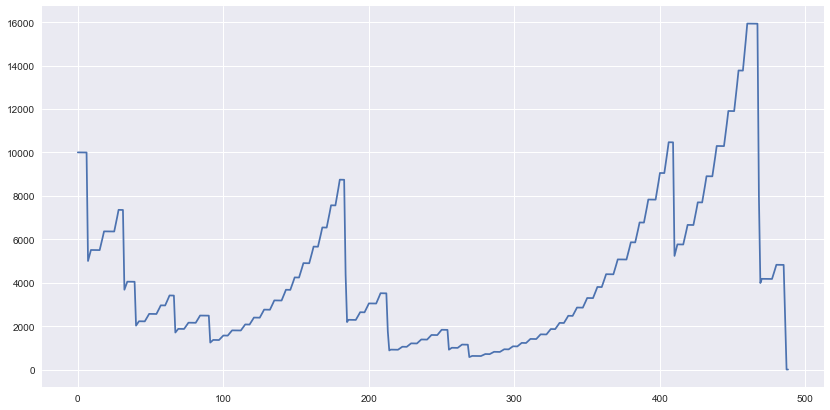

In [44]:
pig_one_cash = 10000
# 1.0全仓买入
buy_rate = 1.0
pig_one_capital = execute_trade(pig_one_cash, buy_rate)
print('猪老大最终资产：{}'.format(pig_one_capital[-1]))
print('猪老大资产最高峰值：{}'.format(max(pig_one_capital)))
plt.plot(pig_one_capital)

猪老二最终资产：8918.155205379582
猪老二资产最高峰值：36596.11504927976


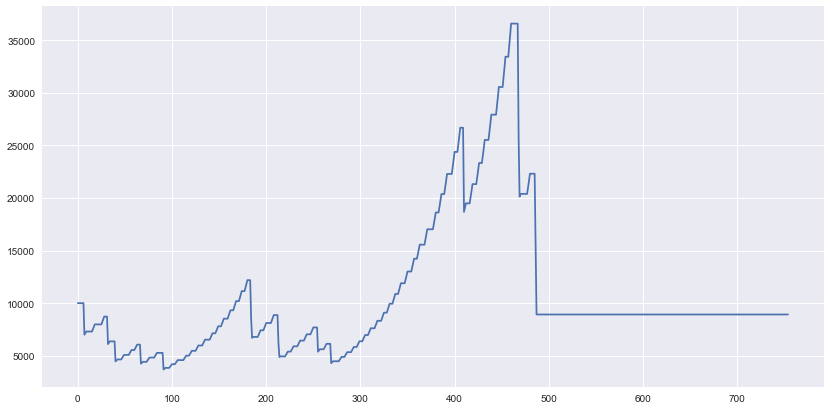

In [43]:
pig_two_cash = 10000
# fwin0.8 -floss0.2 = 0.6 60%仓位买入
buy_rate = 0.8 - 0.2 
pig_two_capital = execute_trade(pig_two_cash, buy_rate)
print('猪老二最终资产：{}'.format(pig_two_capital[-1]))
print('猪老二资产最高峰值：{}'.format(max(pig_two_capital)))
plt.plot(pig_two_capital)

猪老三最终资产：11881.745493052607
猪老三资产最高峰值：14925.091954081347


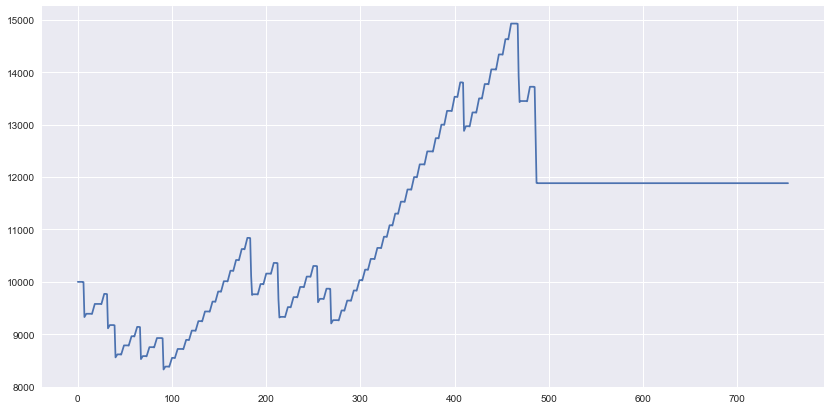

In [42]:
pig_three_cash = 10000
# 最终buy_rate＝0.13即13%仓位
buy_rate = 0.8 - 0.2/(0.15/0.5) 
pig_three_capital = execute_trade(pig_three_cash, buy_rate)
print('猪老三最终资产：{}'.format(pig_three_capital[-1]))
print('猪老三资产最高峰值：{}'.format(max(pig_three_capital)))
plt.plot(pig_three_capital)